## Experiment: Resnet-18 vs AlexNet vs MobileNet 

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import torchvision
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm

import tensorflow as tf

import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim

from sklearn.model_selection import KFold
import seaborn as sns

### AlexNet (baseline)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.RandomCrop((64, 64)),
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = train_transform)
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


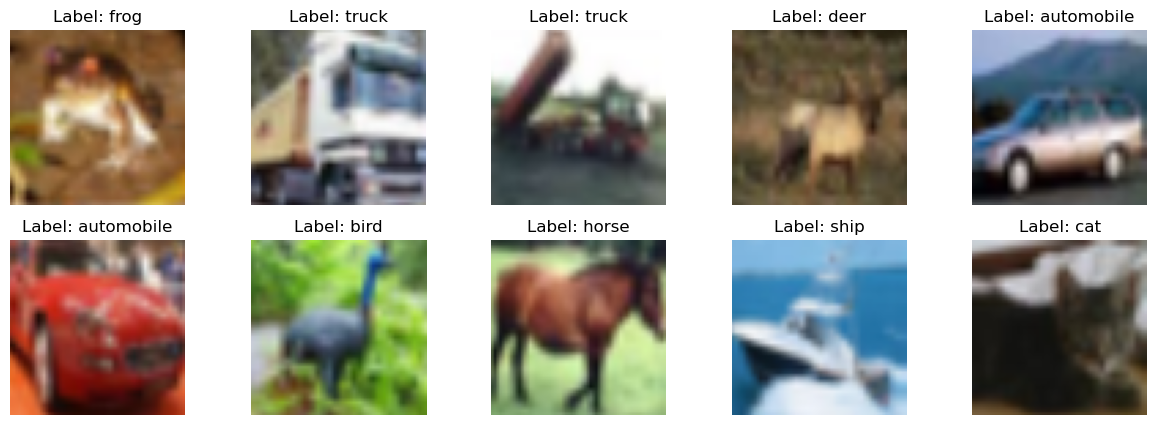

In [20]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Reverse the normalization 
def denormalize(image_tensor, mean, std):
    for i in range(3):
        image_tensor[i] = image_tensor[i] * std[i] + mean[i]
    return image_tensor

plt.figure(figsize=(15, 5))

# Show the first 10 images in the batch
for i in range(10):
    # Denormalize the image
    img = denormalize(images[i], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Convert the tensor to a numpy array and transpose it from (C, H, W) to (H, W, C)
    img = img.numpy().transpose((1, 2, 0))
    # Clip the values to [0, 1] for display
    img = np.clip(img, 0, 1)
    
    # Plot the image
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Label: {train_dataset.classes[labels[i]]}")  
    plt.axis('off')

# Show the plot
plt.show()

In [21]:
##########################
### MODEL
##########################
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [22]:
alexnet = AlexNet(num_classes=10)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True

# Example using KFold cross-validation
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

LEARNING_RATE = 0.01

In [24]:
def train_epoch(model, train_loader, device, optimizer, loss_function):
    model.train() # set model to training mode

    #### For calculation only:
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        #### For calculation only:
        running_train_loss += loss.item() # need this for training too
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()        
        total_train += labels.size(0)

    # Calculate training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = correct_train / total_train
    return avg_train_loss, avg_train_acc


def val_epoch(model, val_loader, device, loss_function):
    model.eval()
    val_loss = 0.0
    correct = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            #### For calculation only:
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total_val += labels.size(0)   

    # Calculate validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = correct / total_val
    return avg_val_loss, avg_val_acc

# Function to save model checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)  # Save the checkpoint

In [25]:
# History for all K-Folds = (overall metrics)
fold_train_loss_history1 = []
fold_train_acc_history1 = []
fold_val_loss_history1 = []
fold_val_acc_history1 = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold+1}/{K_FOLDS}")

    # Create training and validation datasets based on the indices
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory=True)
    val_loader  = DataLoader(val_subset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

    # Train the model on the current fold
    model = AlexNet(num_classes=10) 
    model = model.to(device)
    # model = torch.nn.DataParallel(model) # parallelize a model across multiple GPUs(if got)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum = 0.9, weight_decay = 0.0002)
    # Loss function 
    loss_function = nn.CrossEntropyLoss()

    # Track metrics for the current fold
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []

    ##################
    # Training ......
    num_epochs = 20
    for epoch in range(num_epochs):
        ##################
        # Training on the training fold
        avg_train_loss, avg_train_acc = train_epoch(model, train_loader, device, optimizer, loss_function)
        train_loss_per_epoch.append(avg_train_loss)
        train_acc_per_epoch.append(avg_train_acc)

        ##################
        # Evaluate on the validation fold
        avg_val_loss, avg_val_acc = val_epoch(model, val_loader, device, loss_function)
        val_loss_per_epoch.append(avg_val_loss)
        val_acc_per_epoch.append(avg_val_acc)

        # Print stats for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc*100:.2f}%, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc*100:.2f}%")
    
    # After each folds, save the checkpoint
    save_checkpoint(model, optimizer, epoch, np.mean(train_loss_per_epoch), f'alexnet_checkpoint/checkpoint_fold_{fold+1}.pth')

    # Store this fold only - calculate average loss and accuracy
    fold_train_loss_history1.append(np.mean(train_loss_per_epoch))
    fold_train_acc_history1.append(np.mean(train_acc_per_epoch))
    fold_val_loss_history1.append(np.mean(val_loss_per_epoch))
    fold_val_acc_history1.append(np.mean(val_acc_per_epoch))




Fold 1/5
Epoch 1/20 - Train Loss: 2.1423, Train Accuracy: 16.40%, Val Loss: 1.8385, Val Accuracy: 26.48%
Epoch 2/20 - Train Loss: 1.6658, Train Accuracy: 36.09%, Val Loss: 1.5709, Val Accuracy: 40.72%
Epoch 3/20 - Train Loss: 1.3948, Train Accuracy: 47.97%, Val Loss: 1.2337, Val Accuracy: 55.44%
Epoch 4/20 - Train Loss: 1.2059, Train Accuracy: 56.59%, Val Loss: 1.1650, Val Accuracy: 57.75%
Epoch 5/20 - Train Loss: 1.0857, Train Accuracy: 61.50%, Val Loss: 1.0746, Val Accuracy: 62.19%
Epoch 6/20 - Train Loss: 0.9819, Train Accuracy: 65.39%, Val Loss: 0.9845, Val Accuracy: 65.97%
Epoch 7/20 - Train Loss: 0.8973, Train Accuracy: 68.67%, Val Loss: 0.9268, Val Accuracy: 67.74%
Epoch 8/20 - Train Loss: 0.8308, Train Accuracy: 71.08%, Val Loss: 0.8916, Val Accuracy: 68.88%
Epoch 9/20 - Train Loss: 0.7863, Train Accuracy: 72.45%, Val Loss: 0.8208, Val Accuracy: 71.97%
Epoch 10/20 - Train Loss: 0.7248, Train Accuracy: 74.81%, Val Loss: 0.7637, Val Accuracy: 73.94%
Epoch 11/20 - Train Loss: 0.69

In [26]:
import pandas as pd

# Create a DataFrame to store all the metrics
df = pd.DataFrame({
    'train_loss': fold_train_loss_history1,
    'val_loss': fold_val_loss_history1,
    'train_accuracy': fold_train_acc_history1,
    'val_accuracy': fold_val_acc_history1
})

# Save to CSV
df.to_csv('alexnet_metrics.csv', index=False)

print(df)

   train_loss  val_loss  train_accuracy  val_accuracy
0    0.857230  0.927208        0.691284      0.674395
1    0.849943  0.927084        0.694024      0.674180
2    0.862533  0.940283        0.689124      0.669875
3    0.856535  0.928199        0.690926      0.675370
4    0.874467  0.983045        0.683250      0.657585


### ResNet-18 (baseline)

In [51]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes) 
        
        self.conv2 = nn.Conv2d(planes,planes,kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Identity() 
        if stride != 1:            
            self.shortcut = nn.Sequential(
                            nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                            nn.BatchNorm2d(planes)
                            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride = 1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride = 2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride = 2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride = 2)
        self.linear = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1) 
        out = self.linear(out)
        
        return out

In [52]:
def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [54]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = train_transform)
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
# History for all K-Folds = (overall metrics)
fold_train_loss_history = []
fold_train_acc_history = []
fold_val_loss_history = []
fold_val_acc_history = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold+1}/{K_FOLDS}")

    # Create training and validation datasets based on the indices
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory=True)
    val_loader  = DataLoader(val_subset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

    # Train the model on the current fold
    model = ResNet18() # EfficientNet, default classes = 10
    model = model.to(device)
    # model = torch.nn.DataParallel(model) # parallelize a model across multiple GPUs(if got)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum = 0.9, weight_decay = 0.0002)
    # Loss function 
    loss_function = nn.CrossEntropyLoss()

    # Track metrics for the current fold
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []

    ##################
    # Training ......
    num_epochs = 20
    for epoch in range(num_epochs):
        ##################
        # Training on the training fold
        avg_train_loss, avg_train_acc = train_epoch(model, train_loader, device, optimizer, loss_function)
        train_loss_per_epoch.append(avg_train_loss)
        train_acc_per_epoch.append(avg_train_acc)

        ##################
        # Evaluate on the validation fold
        avg_val_loss, avg_val_acc = val_epoch(model, val_loader, device, loss_function)
        val_loss_per_epoch.append(avg_val_loss)
        val_acc_per_epoch.append(avg_val_acc)

        # Print stats for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc*100:.2f}%, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc*100:.2f}%")
    
    # After each folds, save the checkpoint
    save_checkpoint(model, optimizer, epoch, np.mean(train_loss_per_epoch), f'resnet18_checkpoint/checkpoint_fold_{fold+1}.pth')

    # Store this fold only - calculate average loss and accuracy
    fold_train_loss_history.append(np.mean(train_loss_per_epoch))
    fold_train_acc_history.append(np.mean(train_acc_per_epoch))
    fold_val_loss_history.append(np.mean(val_loss_per_epoch))
    fold_val_acc_history.append(np.mean(val_acc_per_epoch))


Fold 1/5
Epoch 1/20 - Train Loss: 1.5136, Train Accuracy: 44.50%, Val Loss: 1.2377, Val Accuracy: 56.73%
Epoch 2/20 - Train Loss: 1.0087, Train Accuracy: 64.01%, Val Loss: 0.9497, Val Accuracy: 66.36%
Epoch 3/20 - Train Loss: 0.7670, Train Accuracy: 73.26%, Val Loss: 0.7563, Val Accuracy: 73.61%
Epoch 4/20 - Train Loss: 0.6573, Train Accuracy: 76.91%, Val Loss: 0.7294, Val Accuracy: 74.78%
Epoch 5/20 - Train Loss: 0.5733, Train Accuracy: 80.15%, Val Loss: 0.6997, Val Accuracy: 75.49%
Epoch 6/20 - Train Loss: 0.5113, Train Accuracy: 82.18%, Val Loss: 0.5759, Val Accuracy: 80.62%
Epoch 7/20 - Train Loss: 0.4601, Train Accuracy: 83.99%, Val Loss: 0.4977, Val Accuracy: 82.92%
Epoch 8/20 - Train Loss: 0.4279, Train Accuracy: 85.00%, Val Loss: 0.6228, Val Accuracy: 79.44%
Epoch 9/20 - Train Loss: 0.3879, Train Accuracy: 86.57%, Val Loss: 0.4708, Val Accuracy: 84.41%
Epoch 10/20 - Train Loss: 0.3658, Train Accuracy: 87.31%, Val Loss: 0.4677, Val Accuracy: 84.22%
Epoch 11/20 - Train Loss: 0.33

### 3. EfficientNetB0 (baseline)

In [2]:
import torch.nn as nn

def swish(x):
    return x * x.sigmoid()


def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernoulli_(keep_ratio)
    x.div_(keep_ratio)
    x.mul_(mask)
    return x


class SE(nn.Module):
    '''Squeeze-and-Excitation block with Swish.'''

    def __init__(self, in_channels, se_channels):
        super(SE, self).__init__()
        self.se1 = nn.Conv2d(in_channels, se_channels,
                             kernel_size=1, bias=True)
        self.se2 = nn.Conv2d(se_channels, in_channels,
                             kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1))
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out
        return out


class Block(nn.Module):
    '''expansion + depthwise + pointwise + squeeze-excitation'''

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 expand_ratio=1,
                 se_ratio=0.,
                 drop_rate=0.):
        super(Block, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.expand_ratio = expand_ratio

        # Expansion
        channels = expand_ratio * in_channels
        self.conv1 = nn.Conv2d(in_channels,
                               channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        # Depthwise conv
        self.conv2 = nn.Conv2d(channels,
                               channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=(1 if kernel_size == 3 else 2),
                               groups=channels,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        # SE layers
        se_channels = int(in_channels * se_ratio)
        self.se = SE(channels, se_channels)

        # Output
        self.conv3 = nn.Conv2d(channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Skip connection if in and out shapes are the same (MV-V2 style)
        self.has_skip = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0:
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg['out_channels'][-1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size',
                                     'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    Block(in_channels,
                          out_channels,
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out


def EfficientNetB0():
    cfg = {
        'num_blocks': [1, 2, 2, 3, 3, 4, 1],
        'expansion': [1, 6, 6, 6, 6, 6, 6],
        'out_channels': [16, 24, 40, 80, 112, 192, 320],
        'kernel_size': [3, 3, 5, 3, 5, 5, 3],
        'stride': [1, 2, 2, 2, 1, 2, 1],
        'dropout_rate': 0.2,
        'drop_connect_rate': 0.2,
    }
    return EfficientNet(cfg)

In [3]:
model = EfficientNetB0()
model.eval()

EfficientNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SE(
        (se1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (se2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(16, 96, kernel_size=(1, 1), stride=(

In [31]:

# History for all K-Folds = (overall metrics)
fold_train_loss_history2 = []
fold_train_acc_history2 = []
fold_val_loss_history2 = []
fold_val_acc_history2 = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold+1}/{K_FOLDS}")

    # Create training and validation datasets based on the indices
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory=True)
    val_loader  = DataLoader(val_subset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

    # Train the model on the current fold
    model = EfficientNetB0() # EfficientNet, default classes = 10
    model = model.to(device)
    # model = torch.nn.DataParallel(model) # parallelize a model across multiple GPUs(if got)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum = 0.9, weight_decay = 0.0002)
    # Loss function 
    loss_function = nn.CrossEntropyLoss()

    # Track metrics for the current fold
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []

    ##################
    # Training ......
    num_epochs = 20
    for epoch in range(num_epochs):
        ##################
        # Training on the training fold
        avg_train_loss, avg_train_acc = train_epoch(model, train_loader, device, optimizer, loss_function)
        train_loss_per_epoch.append(avg_train_loss)
        train_acc_per_epoch.append(avg_train_acc)

        ##################
        # Evaluate on the validation fold
        avg_val_loss, avg_val_acc = val_epoch(model, val_loader, device, loss_function)
        val_loss_per_epoch.append(avg_val_loss)
        val_acc_per_epoch.append(avg_val_acc)

        # Print stats for the current epoch
        print(f"Epoch {epoch+1}/{num_epochs} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc*100:.2f}%, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_acc*100:.2f}%")
    
    # After each folds, save the checkpoint
    save_checkpoint(model, optimizer, epoch, np.mean(train_loss_per_epoch), f'efficientnetb0_checkpoint/checkpoint_fold_{fold+1}.pth')

    # Store this fold only - calculate average loss and accuracy
    fold_train_loss_history2.append(np.mean(train_loss_per_epoch))
    fold_train_acc_history2.append(np.mean(train_acc_per_epoch))
    fold_val_loss_history2.append(np.mean(val_loss_per_epoch))
    fold_val_acc_history2.append(np.mean(val_acc_per_epoch))


Fold 1/5
Epoch 1/20 - Train Loss: 1.5800, Train Accuracy: 41.40%, Val Loss: 1.3182, Val Accuracy: 52.29%
Epoch 2/20 - Train Loss: 1.0839, Train Accuracy: 61.33%, Val Loss: 0.9456, Val Accuracy: 65.61%
Epoch 3/20 - Train Loss: 0.8190, Train Accuracy: 71.06%, Val Loss: 0.7800, Val Accuracy: 72.56%
Epoch 4/20 - Train Loss: 0.6624, Train Accuracy: 76.89%, Val Loss: 0.6773, Val Accuracy: 76.97%
Epoch 5/20 - Train Loss: 0.5697, Train Accuracy: 80.20%, Val Loss: 0.6305, Val Accuracy: 77.94%
Epoch 6/20 - Train Loss: 0.5055, Train Accuracy: 82.51%, Val Loss: 0.5701, Val Accuracy: 81.15%
Epoch 7/20 - Train Loss: 0.4527, Train Accuracy: 84.27%, Val Loss: 0.5367, Val Accuracy: 81.45%
Epoch 8/20 - Train Loss: 0.4092, Train Accuracy: 85.84%, Val Loss: 0.5595, Val Accuracy: 81.69%
Epoch 9/20 - Train Loss: 0.3687, Train Accuracy: 87.20%, Val Loss: 0.5167, Val Accuracy: 82.73%
Epoch 10/20 - Train Loss: 0.3390, Train Accuracy: 88.07%, Val Loss: 0.5113, Val Accuracy: 82.55%
Epoch 11/20 - Train Loss: 0.30

In [ ]:
################3
## This is just for saving the results for each models
import re
import pandas as pd
import numpy as np
# Define a function to parse the log file and calculate the averages
def parse_log_file(log_file):
    # Initialize lists to store data for each fold
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Read the file content
    with open(log_file, 'r') as f:
        lines = f.readlines()

    # Initialize temporary lists to hold the values for each fold
    temp_train_loss = []
    temp_train_accuracy = []
    temp_val_loss = []
    temp_val_accuracy = []

    # Regular expression pattern to capture the necessary log values
    epoch_pattern = re.compile(
        r"Epoch (\d+)/\d+ - Train Loss: ([\d.]+), Train Accuracy: ([\d.]+)%, "
        r"Val Loss: ([\d.]+), Val Accuracy: ([\d.]+)%"
    )

    # Loop over the lines and extract the data
    for line in lines:
        # If a line matches the epoch pattern, extract the values
        match = epoch_pattern.match(line)
        if match:
            epoch = int(match.group(1))
            train_loss = float(match.group(2))
            train_accuracy = float(match.group(3))
            val_loss = float(match.group(4))
            val_accuracy = float(match.group(5))

            # Append the values to the temporary lists for this fold
            temp_train_loss.append(train_loss)
            temp_train_accuracy.append(train_accuracy)
            temp_val_loss.append(val_loss)
            temp_val_accuracy.append(val_accuracy)

        # If a new fold is encountered (i.e., "Fold x/y"), save the results for the previous fold
        elif line.startswith("Fold"):
            # If we already have values from a previous fold, save them
            if temp_train_loss:
                train_losses.append(temp_train_loss)
                train_accuracies.append(temp_train_accuracy)
                val_losses.append(temp_val_loss)
                val_accuracies.append(temp_val_accuracy)

            # Reset temporary lists for the next fold
            temp_train_loss = []
            temp_train_accuracy = []
            temp_val_loss = []
            temp_val_accuracy = []

    # Append the last fold's results
    if temp_train_loss:
        train_losses.append(temp_train_loss)
        train_accuracies.append(temp_train_accuracy)
        val_losses.append(temp_val_loss)
        val_accuracies.append(temp_val_accuracy)

    # Convert lists to numpy arrays for easier manipulation
    train_losses = np.array(train_losses)
    train_accuracies = np.array(train_accuracies)
    val_losses = np.array(val_losses)
    val_accuracies = np.array(val_accuracies)

    return train_losses, train_accuracies, val_losses, val_accuracies

# Function to calculate average for each epoch across all folds
def calculate_averages(train_losses, train_accuracies, val_losses, val_accuracies):
    avg_train_losses = np.mean(train_losses, axis=0)
    avg_train_accuracies = np.mean(train_accuracies, axis=0)
    avg_val_losses = np.mean(val_losses, axis=0)
    avg_val_accuracies = np.mean(val_accuracies, axis=0)

    return avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies

# Function to save the results to a CSV file
def save_results_to_csv(avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies):
    # Create a DataFrame to store the results
    df = pd.DataFrame({
        'Epoch': np.arange(1, len(avg_train_losses) + 1),
        'Avg Train Loss': avg_train_losses,
        'Avg Train Accuracy': avg_train_accuracies,
        'Avg Val Loss': avg_val_losses,
        'Avg Val Accuracy': avg_val_accuracies
    })

    return df



In [59]:
log_file = 'model_results/resnet18.txt'  #

train_losses, train_accuracies, val_losses, val_accuracies = parse_log_file(log_file)

# Calculate the averages for each epoch
avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies = calculate_averages(
    train_losses, train_accuracies, val_losses, val_accuracies
)

# Save the averaged results to a CSV file
df = save_results_to_csv(avg_train_losses, avg_train_accuracies, avg_val_losses, avg_val_accuracies)
print(df)
df.to_csv('model_results/training_result_resnet18.csv', index=False)

    Epoch  Avg Train Loss  Avg Train Accuracy  Avg Val Loss  Avg Val Accuracy
0       1         1.50162              44.968       1.33924            52.918
1       2         1.01546              63.874       1.08618            63.200
2       3         0.78502              72.498       0.81636            71.782
3       4         0.66044              76.942       0.80646            72.584
4       5         0.57580              80.050       0.68492            76.652
5       6         0.51266              82.214       0.59928            79.648
6       7         0.46414              83.894       0.52258            82.138
7       8         0.42438              85.232       0.55666            81.258
8       9         0.38928              86.476       0.54714            81.834
9      10         0.36566              87.408       0.49866            83.264
10     11         0.33950              88.256       0.45668            84.628
11     12         0.31206              89.132       0.46442     

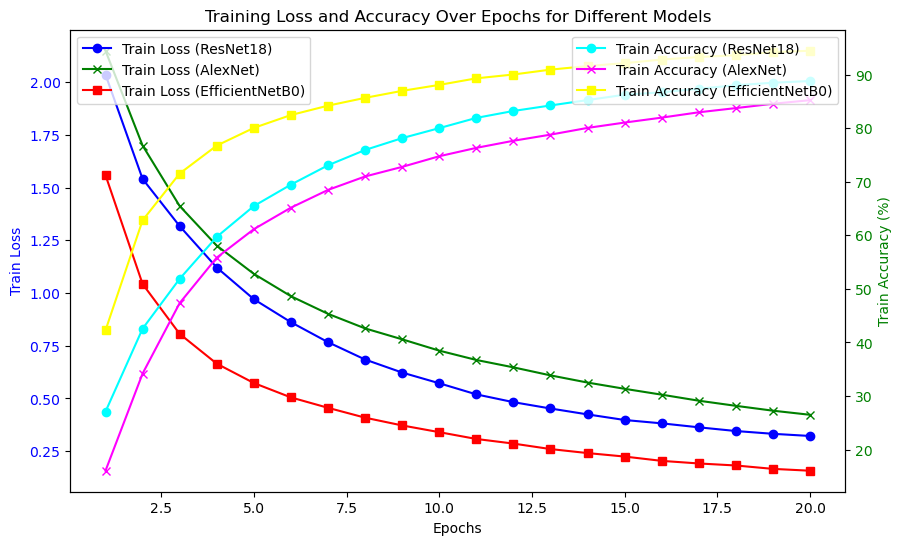

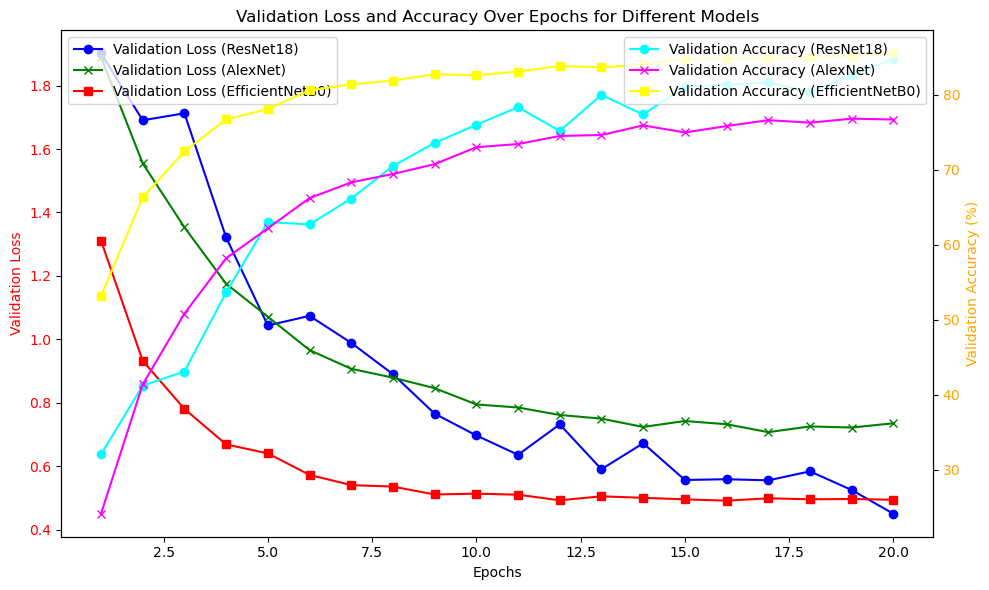

In [50]:
df1 = pd.read_csv('model_results/training_result_resnet18.csv')
df2 = pd.read_csv('model_results/training_result_alexnet.csv')
df3 = pd.read_csv('model_results/training_result_efficientnetb0.csv')


epochs1 = df1['Epoch']
train_loss1 = df1['Avg Train Loss']
train_accuracy1 = df1['Avg Train Accuracy']
val_loss1 = df1['Avg Val Loss']
val_accuracy1 = df1['Avg Val Accuracy']

epochs2 = df2['Epoch']
train_loss2 = df2['Avg Train Loss']
train_accuracy2 = df2['Avg Train Accuracy']
val_loss2 = df2['Avg Val Loss']
val_accuracy2 = df2['Avg Val Accuracy']

epochs3 = df3['Epoch']
train_loss3 = df3['Avg Train Loss']
train_accuracy3 = df3['Avg Train Accuracy']
val_loss3 = df3['Avg Val Loss']
val_accuracy3 = df3['Avg Val Accuracy']

# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss for each learning rate
ax1.plot(epochs1, train_loss1, label='Train Loss (ResNet18)', color='blue', linestyle='-', marker='o')
ax1.plot(epochs2, train_loss2, label='Train Loss (AlexNet)', color='green', linestyle='-', marker='x')
ax1.plot(epochs3, train_loss3, label='Train Loss (EfficientNetB0)', color='red', linestyle='-', marker='s')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Training Loss and Accuracy Over Epochs for Different Models')

# Create a second y-axis for Training Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs1, train_accuracy1, label='Train Accuracy (ResNet18)', color='cyan', linestyle='-', marker='o')
ax2.plot(epochs2, train_accuracy2, label='Train Accuracy (AlexNet)', color='magenta', linestyle='-', marker='x')
ax2.plot(epochs3, train_accuracy3, label='Train Accuracy (EfficientNetB0)', color='yellow', linestyle='-', marker='s')
ax2.set_ylabel('Train Accuracy (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot Validation Loss and Accuracy with a new set of axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Validation Loss for each learning rate
ax1.plot(epochs1, val_loss1, label='Validation Loss (ResNet18)', color='blue', linestyle='-', marker='o')
ax1.plot(epochs2, val_loss2, label='Validation Loss (AlexNet)', color='green', linestyle='-', marker='x')
ax1.plot(epochs3, val_loss3, label='Validation Loss (EfficientNetB0)', color='red', linestyle='-', marker='s')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title('Validation Loss and Accuracy Over Epochs for Different Models')

# Create a second y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(epochs1, val_accuracy1, label='Validation Accuracy (ResNet18)', color='cyan', linestyle='-', marker='o')
ax2.plot(epochs2, val_accuracy2, label='Validation Accuracy (AlexNet)', color='magenta', linestyle='-', marker='x')
ax2.plot(epochs3, val_accuracy3, label='Validation Accuracy (EfficientNetB0)', color='yellow', linestyle='-', marker='s')
ax2.set_ylabel('Validation Accuracy (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plots
plt.tight_layout()
plt.show()


### Evaluation metrics: 
- Classification Report
- AUC-ROC Curve
- Precision-Recall Curve
- Confusion matrix

In [68]:
# Testing: Reload the checkpoint model, used it for evaluation
reload_alexnet = AlexNet(num_classes=10)
checkpoint = torch.load(f'alexnet_checkpoint/checkpoint_fold_{K_FOLDS}.pth')
reload_alexnet.load_state_dict(checkpoint['model_state_dict'])
reload_alexnet = reload_alexnet.to(device)
reload_alexnet.eval()

reload_efficientnetb0 = EfficientNetB0()
checkpoint = torch.load(f'efficientnetb0_checkpoint/checkpoint_fold_{K_FOLDS}.pth')
reload_efficientnetb0.load_state_dict(checkpoint['model_state_dict'])
reload_efficientnetb0 = reload_efficientnetb0.to(device)
reload_efficientnetb0.eval()

reload_resnet18 = ResNet18()
checkpoint = torch.load(f'resnet18_checkpoint/checkpoint_fold_{K_FOLDS}.pth')
reload_resnet18.load_state_dict(checkpoint['model_state_dict'])
reload_resnet18 = reload_resnet18.to(device)
reload_resnet18.eval()

print()


In [66]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, precision_score
import seaborn as sns 

#####
# AUC-ROC Curve
def plot_roc_curve(y_true, y_scores, unique_classes):
    unique_classes = np.unique(y_true)
    y_true_bin = label_binarize(y_true, classes=unique_classes)  

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(unique_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    # Macro average
    macro_roc_auc = np.mean(list(roc_auc.values()))
    print(f'Macro-average ROC AUC: {macro_roc_auc:0.2f}')


#####
# Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_scores, unique_classes):
    y_true_bin = label_binarize(y_true, classes=unique_classes) 
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(unique_classes)):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_scores[:, i])
        
        # Plot Precision-Recall curve for each class
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

# m = model, l = loader, d = device
def get_predictions(m, l, d):
    y_true = []
    y_scores = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in l:  
            inputs, targets = inputs.to(d), targets.to(d)
            outputs = m(inputs)

            # Get the predicted class labels
            _, predicted = torch.max(outputs, 1)

            y_true.extend(targets.cpu().numpy())  # Add true labels
            y_scores.extend(outputs.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Convert y_true and y_pred to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    y_pred = np.array(y_pred)

    return y_true, y_scores, y_pred

#####
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, unique_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes, cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Files already downloaded and verified
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.78      0.91      0.84      1000
           2       0.71      0.70      0.70      1000
           3       0.53      0.68      0.60      1000
           4       0.73      0.72      0.72      1000
           5       0.74      0.60      0.66      1000
           6       0.78      0.84      0.81      1000
           7       0.91      0.73      0.81      1000
           8       0.82      0.89      0.85      1000
           9       0.92      0.71      0.80      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



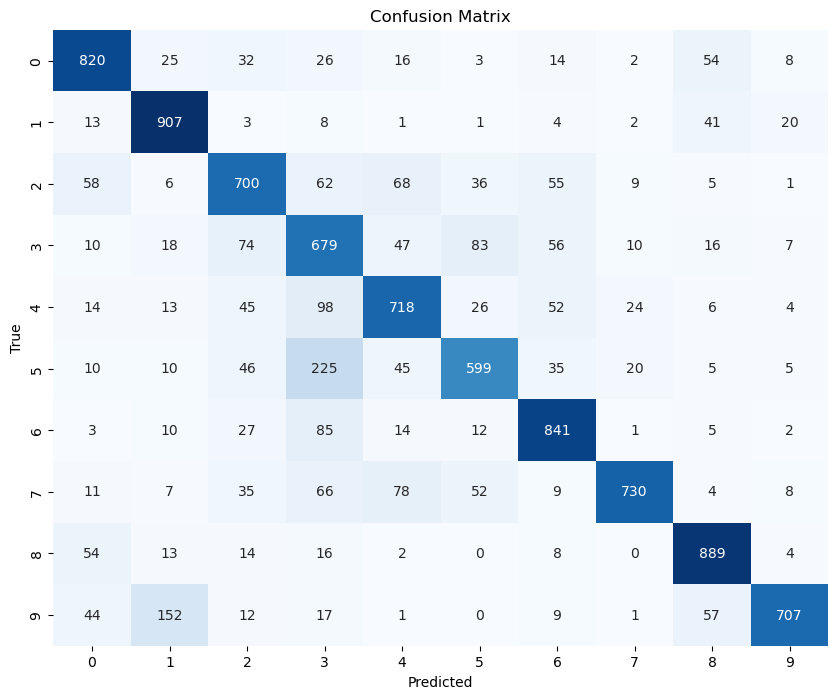

In [ ]:
##### Evaluation for AlexNet
# Load test dataset (use DataLoader to batch it)
test_transform = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = test_transform)
test_loader  = DataLoader(test_dataset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

y_true, y_scores, y_pred = get_predictions(reload_alexnet, test_loader, device)
#####
# classification_report
print(classification_report(y_true, y_pred))
unique_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_confusion_matrix(y_true, y_pred, unique_classes)

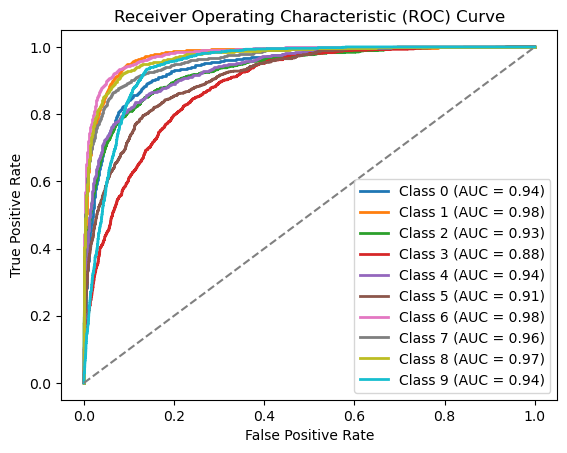

Macro-average ROC AUC: 0.94


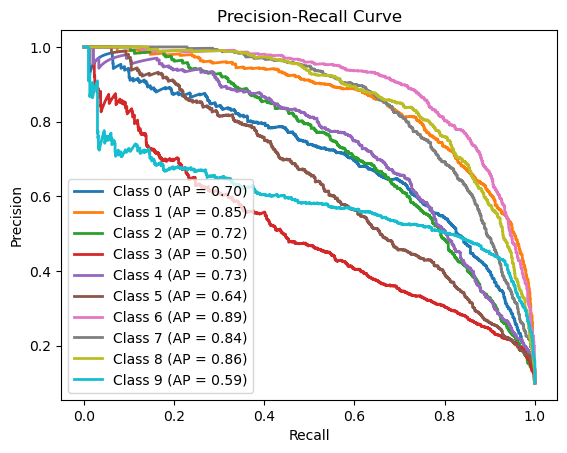

In [71]:
plot_roc_curve(y_true, y_scores, unique_classes)
plot_precision_recall_curve(y_true, y_scores, unique_classes)

Files already downloaded and verified
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1000
           1       0.97      0.94      0.95      1000
           2       0.82      0.86      0.84      1000
           3       0.76      0.77      0.77      1000
           4       0.87      0.89      0.88      1000
           5       0.91      0.74      0.82      1000
           6       0.93      0.92      0.92      1000
           7       0.86      0.95      0.90      1000
           8       0.94      0.94      0.94      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



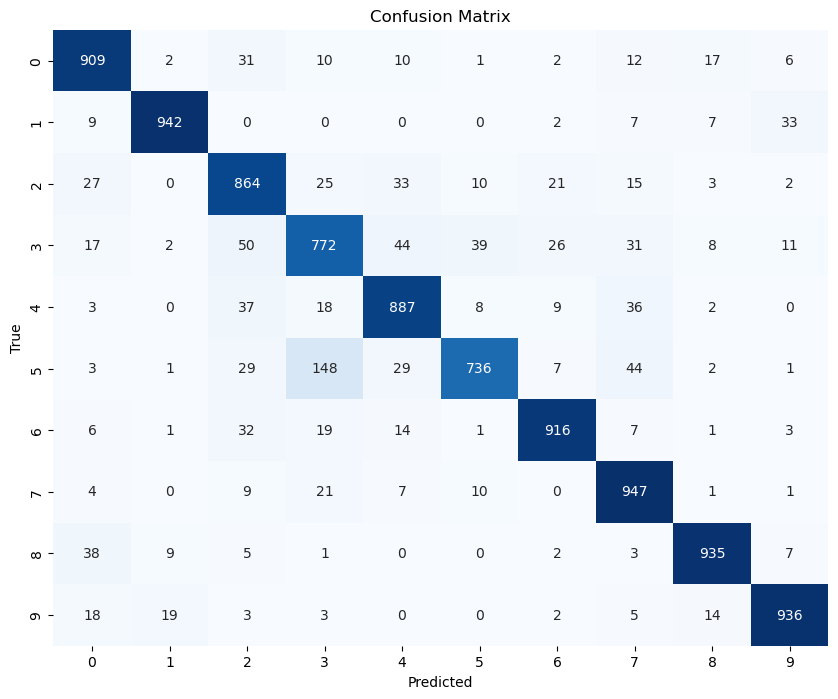

In [72]:
##### ##### ##### ##### ##### 
##### Evaluation for ResNet-18
# Load test dataset (use DataLoader to batch it)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = test_transform)
test_loader  = DataLoader(test_dataset, batch_size = 100, shuffle = False, num_workers = 4, pin_memory=True)

y_true, y_scores, y_pred = get_predictions(reload_resnet18, test_loader, device)
#####
# classification_report
print(classification_report(y_true, y_pred))
unique_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_confusion_matrix(y_true, y_pred, unique_classes)

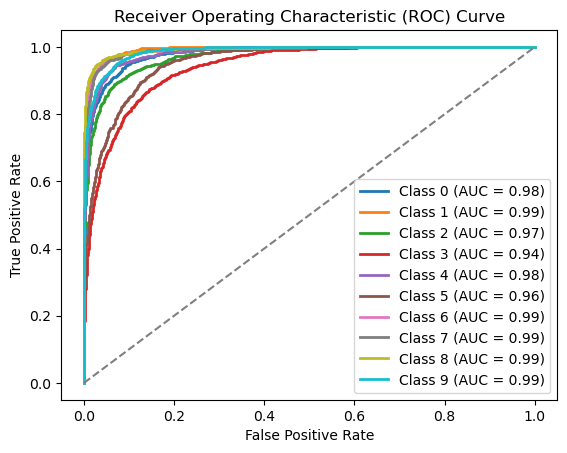

Macro-average ROC AUC: 0.98


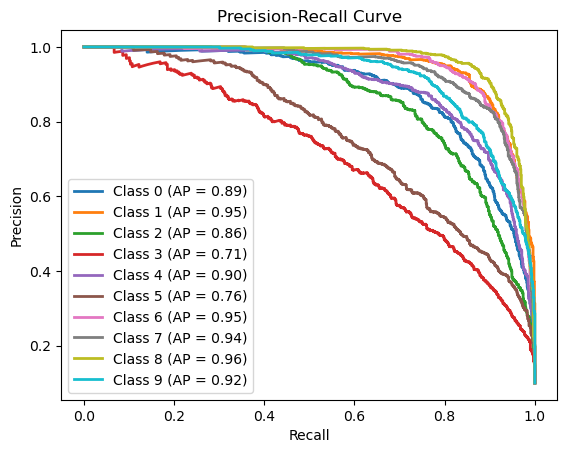

In [73]:
plot_roc_curve(y_true, y_scores, unique_classes)
plot_precision_recall_curve(y_true, y_scores, unique_classes)

              precision    recall  f1-score   support

           0       0.46      0.60      0.52      1000
           1       0.56      0.69      0.62      1000
           2       1.00      0.00      0.00      1000
           3       0.29      0.51      0.37      1000
           4       0.51      0.21      0.30      1000
           5       0.74      0.07      0.13      1000
           6       0.38      0.69      0.49      1000
           7       0.64      0.10      0.18      1000
           8       0.86      0.35      0.50      1000
           9       0.29      0.81      0.43      1000

    accuracy                           0.40     10000
   macro avg       0.57      0.40      0.35     10000
weighted avg       0.57      0.40      0.35     10000



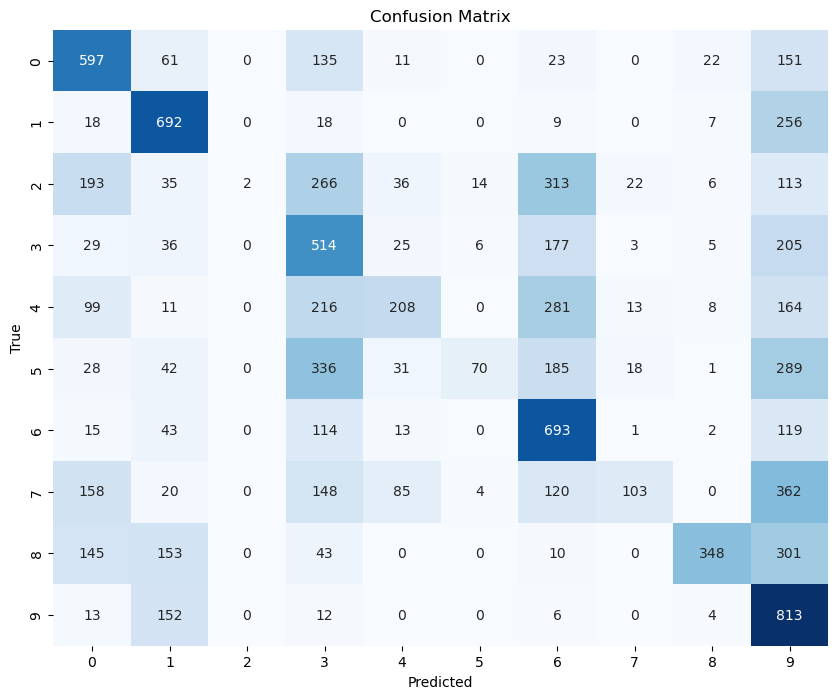

In [74]:
##### ##### ##### ##### ##### 
##### Evaluation for EfficientNetB0
y_true, y_scores, y_pred = get_predictions(reload_efficientnetb0, test_loader, device)
#####
# classification_report
print(classification_report(y_true, y_pred))
unique_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_confusion_matrix(y_true, y_pred, unique_classes)

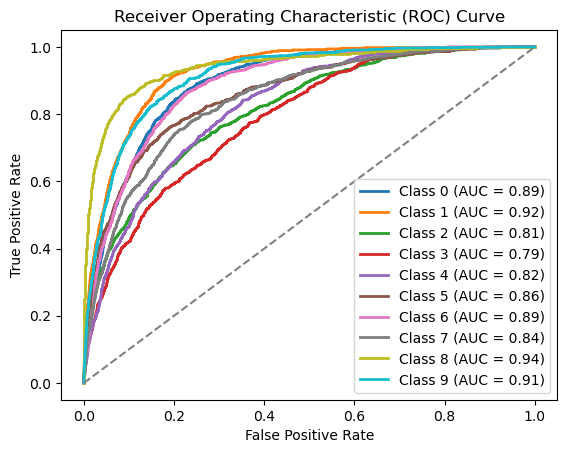

Macro-average ROC AUC: 0.87


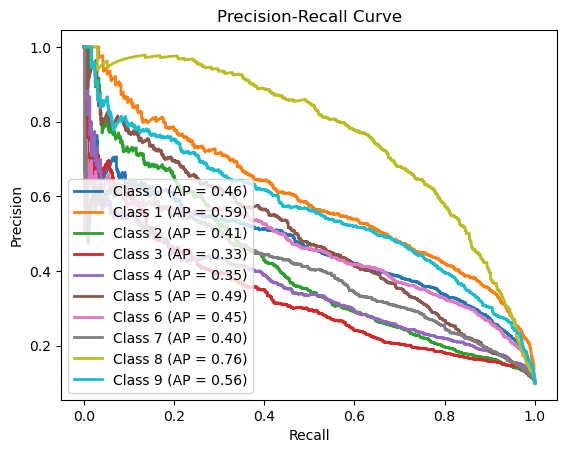

In [75]:
plot_roc_curve(y_true, y_scores, unique_classes)
plot_precision_recall_curve(y_true, y_scores, unique_classes)